#### Directories etc

In [299]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import re
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode, median

In [300]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [301]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [302]:
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)   

In [303]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

##### Plot p values for known CDS

In [304]:
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'].isin(['CDS','rRNA','tRNA'])][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology','Feature']]      #Just CDS
mycobrowser_all_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_all_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology'], r['Feature']))
mycobrowser_all_boundaries.sort(key = lambda x: x[2])

In [305]:
min_intergenic_length = 100
mycobrowser_upstream_inter_cds_boundaries = []
for n,cds in enumerate(mycobrowser_all_boundaries):
    if not(cds[8] == 'CDS'):
        continue
    strand = cds[4]
    start = cds[2]
    stop = cds[3]
    if strand == 1:
        max_stop = 0
        for feat in mycobrowser_all_boundaries:
            if feat[2] < start:
                max_stop = max(max_stop, feat[3])
        if start > max_stop + min_intergenic_length:
                mycobrowser_upstream_inter_cds_boundaries.append((cds[0], cds[1], max_stop, start, cds[4], cds[5]))
    if strand == -1:
        min_start = 9999999999
        for feat in mycobrowser_all_boundaries:
            if feat[3] > stop:
                min_start = min(feat[2], min_start)
        if stop + min_intergenic_length < min_start:
                mycobrowser_upstream_inter_cds_boundaries.append((cds[0], cds[1], stop, min_start, cds[4], cds[5]))


In [306]:
min_intergenic_length = 100
mycobrowser_downstream_inter_cds_boundaries = []
for n,cds in enumerate(mycobrowser_all_boundaries):
    if not(cds[8] == 'CDS'):
        continue
    strand = cds[4]
    start = cds[2]
    stop = cds[3]
    if strand == -1:
        max_stop = 0
        for feat in mycobrowser_all_boundaries:
            if feat[2] < start:
                max_stop = max(max_stop, feat[3])
        if start > max_stop + min_intergenic_length:
            mycobrowser_downstream_inter_cds_boundaries.append((cds[0], cds[1], max_stop, start, cds[4], cds[5]))
    if strand == 1:
        min_start = 9999999999
        for feat in mycobrowser_all_boundaries:
            if feat[3] > stop:
                min_start = min(feat[2], min_start)
        if stop + min_intergenic_length < min_start:
                mycobrowser_downstream_inter_cds_boundaries.append((cds[0], cds[1], stop, min_start, cds[4], cds[5]))

In [307]:
upstream_mutation_counts_dict = {}
for info in mycobrowser_upstream_inter_cds_boundaries:
    locus = info[0]
    start = info[2]
    stop = info[3]
    strand = info[4]
    if stop > len(full_sequence):
        continue
    if strand == 1:
        for i in range(start, stop+100):
            relative_position = stop-i-1
            if relative_position in upstream_mutation_counts_dict:
                upstream_mutation_counts_dict[relative_position].append([locus, full_sample_zero_and_non_zero_mutation_counts[i]])
            else:
                upstream_mutation_counts_dict[relative_position] = [[locus, full_sample_zero_and_non_zero_mutation_counts[i]]]      
    if strand == -1:
        for i in range(start-100, stop):
            relative_position = i-start
            if relative_position in upstream_mutation_counts_dict:
                upstream_mutation_counts_dict[relative_position].append([locus, full_sample_zero_and_non_zero_mutation_counts[i]])
            else:
                upstream_mutation_counts_dict[relative_position] = [[locus, full_sample_zero_and_non_zero_mutation_counts[i]]]                     

In [308]:
downstream_mutation_counts_dict = {}
for info in mycobrowser_downstream_inter_cds_boundaries:
    locus = info[0]
    start = info[2]
    stop = info[3]
    strand = info[4]
    if stop > len(full_sequence):
        continue
    if strand == 1:
        for i in range(start-100, stop):
            relative_position = i - start
            if relative_position in downstream_mutation_counts_dict:
                downstream_mutation_counts_dict[relative_position].append([locus, full_sample_zero_and_non_zero_mutation_counts[i]])
            else:
                downstream_mutation_counts_dict[relative_position] = [[locus,full_sample_zero_and_non_zero_mutation_counts[i]]]      
    if strand == -1:
        for i in range(start, stop+100):
            relative_position = stop - i - 1
            if relative_position in downstream_mutation_counts_dict:
                downstream_mutation_counts_dict[relative_position].append([locus,full_sample_zero_and_non_zero_mutation_counts[i]])
            else:
                downstream_mutation_counts_dict[relative_position] = [[locus, full_sample_zero_and_non_zero_mutation_counts[i]]]                   


<AxesSubplot:xlabel='pos', ylabel='ave_mut'>

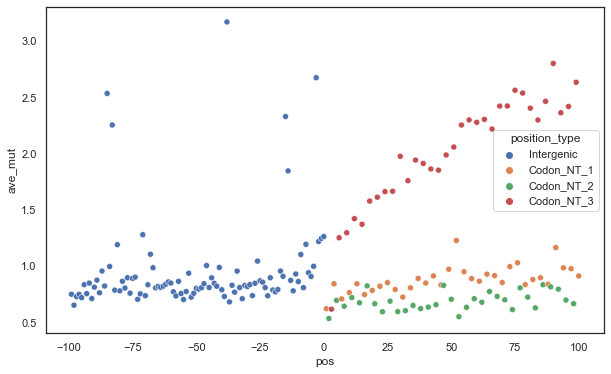

In [323]:
temp = []
for rel, ct in upstream_mutation_counts_dict.items():
    if rel>=0:
        position_type = 'Intergenic'
    else:
        position_type = 'Codon_NT_'+str((abs(rel)+2)%3+1)
    temp.append([-1*rel, sum([x[1] for x in ct if x[1] > 0])/len(ct), position_type, 'Upstream'])     #Plot so that upstream region is shown as negative offset to start codon
upstream_mutation_df = pd.DataFrame(temp, columns = ['pos','ave_mut','position_type','region'])
upstream_mutation_df = upstream_mutation_df[upstream_mutation_df['pos'] > -100]
sns.scatterplot(data = upstream_mutation_df, x = 'pos', y = 'ave_mut', hue = 'position_type')

<AxesSubplot:xlabel='pos', ylabel='ave_mut'>

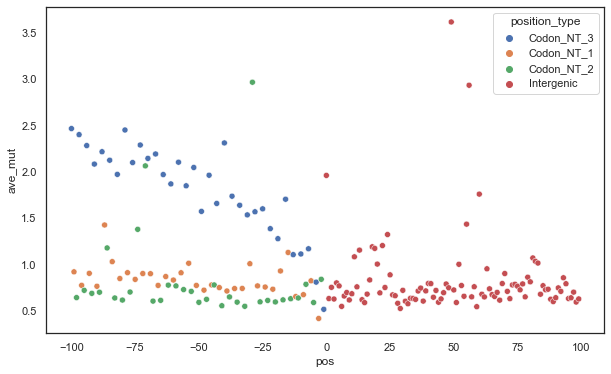

In [324]:
temp = []
for rel, ct in downstream_mutation_counts_dict.items():
    if rel>=0:
        position_type = 'Intergenic'
    else:
        position_type = 'Codon_NT_'+str(((rel))%3+1)
    temp.append([rel, sum([x[1] for x in ct if x[1] > 0])/len(ct), position_type, 'Downstream'])     #Plot so that upstream region is shown as negative offset to start codon
downstream_mutation_df = pd.DataFrame(temp, columns = ['pos','ave_mut','position_type','region'])
downstream_mutation_df = downstream_mutation_df[downstream_mutation_df['pos'] < 100]
sns.scatterplot(data = downstream_mutation_df, x = 'pos', y = 'ave_mut', hue = 'position_type')

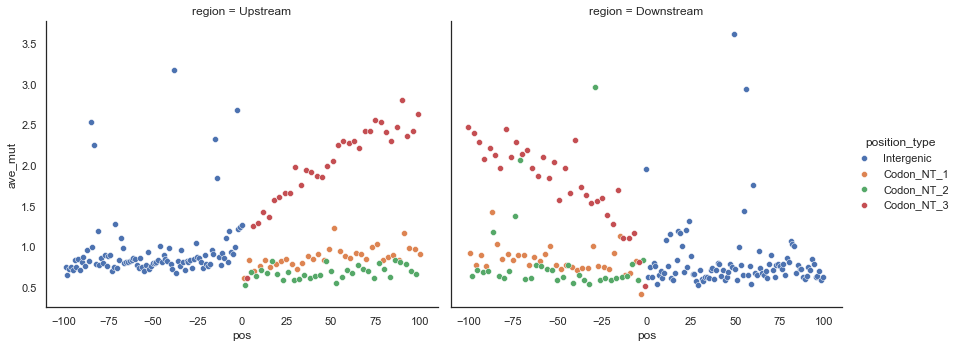

In [325]:
temp = pd.concat([upstream_mutation_df, downstream_mutation_df])
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style(style='white')
g = sns.FacetGrid(temp, col='region', hue = 'position_type', height=5, aspect= 1.2)
g.map(sns.scatterplot, "pos", "ave_mut")
g.add_legend()

In [298]:
def locus_plot(locus_name):

    temp = []
    for rel, ct in upstream_mutation_counts_dict.items():
        if rel>=0:
            position_type = 'Intergenic'
        else:
            position_type = 'Codon_NT_'+str((abs(rel)+2)%3+1)
        temp.append([-1*rel, sum([x[1] for x in ct if x[1] > 0 and x[0] == locus_name]), position_type, 'Upstream'])     #Plot so that upstream region is shown as negative offset to start codon
    temp_df = pd.DataFrame(temp, columns = ['pos','ave_mut','position_type','region'])
    temp_df = upstream_mutation_df[upstream_mutation_df['pos'] > -100]

    temp = []
    for rel, ct in downstream_mutation_counts_dict.items():
        if rel>=0:
            position_type = 'Intergenic'
        else:
            position_type = 'Codon_NT_'+str(((rel))%3+1)
        temp.append([rel, sum([x[1] for x in ct if x[1] > 0 and x[0] == locus_name]), position_type, 'Downstream'])
    temp_df_2 = pd.DataFrame(temp, columns = ['pos','ave_mut','position_type','region'])
    temp_df_2 = downstream_mutation_df[downstream_mutation_df['pos'] < 100]

    temp = pd.concat([temp_df, temp_df_2])
    sns.set(rc={"figure.figsize": (10, 6)})
    sns.set_style(style='white')
    g = sns.FacetGrid(temp, col='region', hue = 'position_type', height=5, aspect= 1.2)
    g.map(sns.scatterplot, "pos", "ave_mut")
    g.add_legend()
    

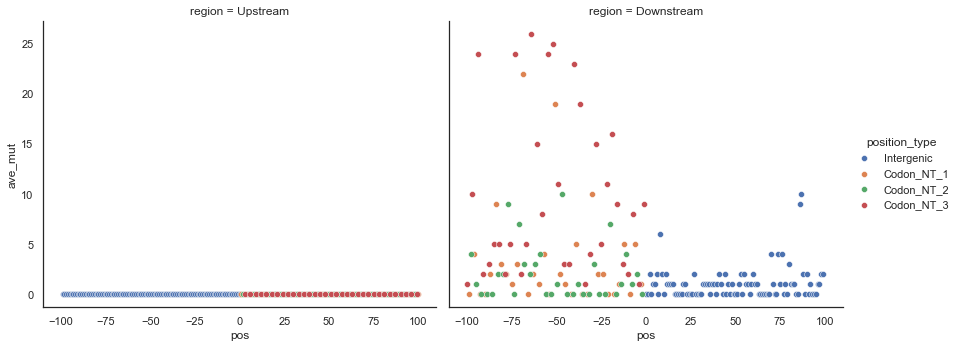

In [294]:
locus_plot('Rv0001')

In [ ]:
#  Do COMPASS overlap